In [1]:
from importlib import reload

import numpy as np
from datetime import timedelta
from fiberis.simulator.core import pds

In [2]:
import pydevd_pycharm

In [153]:
from fiberis.analyzer.Data1D import Data1D_Gauge, Data1D_PumpingCurve
from fiberis.simulator.core import mesh_utils

In [43]:
import os
os.listdir()

['243_22562_220-pycharm-support-libs',
 'test_folder',
 'Phase1.npz',
 '._.DS_Store',
 'data',
 '243_23654_177-pycharm-support-libs',
 'phase3_new.npz',
 'Phase2.npz',
 'pds',
 '.DS_Store',
 'DSS_analyzer_Mariner',
 'Phase3_prev.npz',
 'Phase3.npz']

In [44]:
datapath = "./data"

In [45]:
# Gauge data
gauge_data_folder = datapath + "/gauge_data_swell"

In [46]:
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_Gauge.Data1DGauge()
filepath = gauge_data_folder + f"/gauge6_data_swell.npz"
gauge_dataframe.load_npz(filepath)
filepath_next = gauge_data_folder + f"/gauge7_data_swell.npz"
gauge_dataframe_next = Data1D_Gauge.Data1DGauge()
gauge_dataframe_next.load_npz(filepath)

In [47]:
# Load the pumping data of stage 7
pumping_data_folder = datapath + "/pumping_curve/stage7"
filelist = os.listdir(pumping_data_folder)
filepath = pumping_data_folder + "/" + filelist[0]

pumping_curve_dataframe = Data1D_PumpingCurve.Data1DPumpingCurve()
pumping_curve_dataframe.load_npz(filepath)

In [48]:
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()
filepath_next = datapath + "/pumping_curve/stage8" + "/" + filelist[0]
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1DPumpingCurve()
pumping_curve_dataframe_next.load_npz(filepath_next)
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)

In [49]:
# Load the frac hit data
frac_hit_datapath = datapath + "/geometry/frac_hit/"
from pds.DSS_analyzer_Mariner import Data3D_geometry
frac_hit_dataframe_stage7 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_7_swell.npz")
frac_hit_dataframe_stage8 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_8_swell.npz")

In [50]:
# Load the gauge md data
gauge_md_datapath = datapath + "/geometry/gauge_md_swell.npz"
gauge_md_dataframe = Data3D_geometry.Data3D_geometry(gauge_md_datapath)

In [51]:
# Extract the frac hit data and gauge md data
frac_hit_md_stg7 = frac_hit_dataframe_stage7.data
frac_hit_md_stg8 = frac_hit_dataframe_stage8.data
gauge_md = gauge_md_dataframe.data[4:10]

In [52]:
print(frac_hit_md_stg8)
print(np.round(frac_hit_md_stg8))

[14940.    14976.36  15009.09  15063.63  15100.    15118.182]
[14940. 14976. 15009. 15064. 15100. 15118.]


In [53]:
# define the mesh
dx = 1
nx = 5500
x = np.arange(12500, 12500 + nx * dx, dx)
# refine the mesh round the frac hits
# stage 7, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg7):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)
# stage 8, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg8):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)

In [54]:
# update the number of nodes
nx = len(x)

In [55]:
# update the frac hit index and gauge index
frac_hit_idx_stg7 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg7]
frac_hit_idx_stg8 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg8]
gauge_idx = [mesh_utils.locate(x, gauge_iter)[0] for gauge_iter in gauge_md]

In [56]:
import matplotlib.pyplot as plt

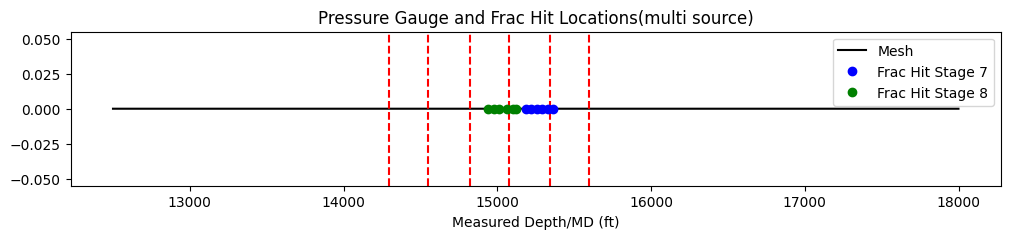

In [57]:
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros_like(x), 'k-', label='Mesh')
for gauge_md_iter in gauge_md:
    # no legend
    plt.axvline(x=gauge_md_iter, color='r', linestyle='--')
plt.plot(frac_hit_md_stg7, np.zeros_like(frac_hit_md_stg7), 'bo', label='Frac Hit Stage 7')
plt.plot(frac_hit_md_stg8, np.zeros_like(frac_hit_md_stg8), 'go', label='Frac Hit Stage 8')
plt.xlabel('Measured Depth/MD (ft)')
plt.title('Pressure Gauge and Frac Hit Locations(multi source)')
plt.legend()
plt.show()

In [58]:
# Set other parameters
d = 140
d_array = np.ones_like(x) * d

t0 = 0 # Phase 1 starts at 0

# Phase 1

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
pds_frame_phase1 = pds.PDS1D_MultiSource()

In [108]:
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d_array)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(t0) # Phase 1 starts at 0

In [109]:
# Set the source idx
pds_frame_phase1.set_sourceidx(frac_hit_idx_stg7)

In [110]:
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)

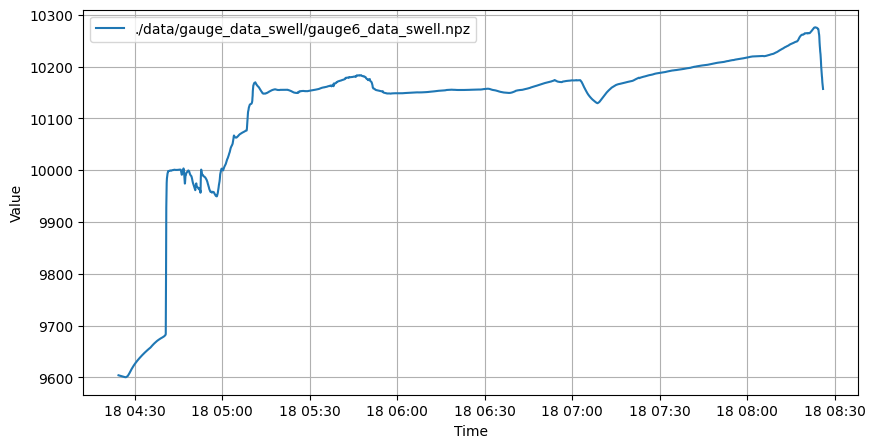

In [111]:
phase_1_pg_dataframe.plot()

In [112]:
# Create the source term array
source_phase1_list = []
for source_iter in range(len(frac_hit_idx_stg7)):
    source_phase1_list.append(phase_1_pg_dataframe)

In [113]:
pds_frame_phase1.set_source(source_phase1_list)

In [114]:
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)

In [116]:
pds_frame_phase1.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 2 Source term: [9604.148, 9604.148, 9604.148, 9604.148, 9604.148, 9604.148]
Time: 32 Source term: [9604.107458052065, 9604.107458052065, 9604.107458052065, 9604.107458052065, 9604.107458052065, 9604.107458052065]
Time: 62 Source term: [9603.294968807346, 9603.294968807346, 9603.294968807346, 9603.294968807346, 9603.294968807346, 9603.294968807346]
Time: 92 Source term: [9602.49368877551, 9602.49368877551, 9602.49368877551, 9602.49368877551, 9602.49368877551, 9602.49368877551]
Time: 122 Source term: [9601.707218860429, 9601.707218860429, 9601.707218860429, 9601.707218860429, 9601.707218860429, 9601.707218860429]
Time: 152 Source term: [9600.881714971214, 9600.881714971214, 9600.881714971214, 9600.881714971214, 9600.881714971214, 9600.881714971214]
Time: 182 Source term: [9600.450051125703, 9600.450051125703, 9600.450051125703, 9600.450051125703, 9600.450051125703, 9600.450051125703]
Time: 212 Source term: [9602.0337284074, 9602.033728407

In [117]:
pds_frame_phase1.source[0].taxis[-1]

14494.11400000006

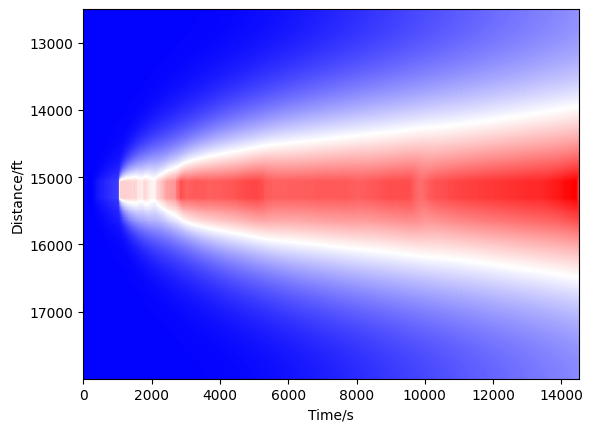

In [129]:
# show the solution
pds_frame_phase1.plot_solution()

# Phase 2

In [118]:
# from importlib import reload
# reload(pds)

In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
# Calculate the total_time
total_time = stage8_start_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [155]:
pds_frame_phase2 = pds.PDS1D_MultiSource()

In [156]:
pds_frame_phase2.set_mesh(x)
pds_frame_phase2.set_diffusivity(d_array)
pds_frame_phase2.set_bcs('Neumann', 'Neumann')

In [157]:
pds_frame_phase2.set_t0(pds_frame_phase1.taxis[-1]) # Phase 2 starts after phase 1

In [158]:
pds_frame_phase2.set_sourceidx(frac_hit_idx_stg7)

In [159]:
# setup the source term for phase 2
phase_2_pg_dataframe = gauge_dataframe.copy()
phase_2_pg_dataframe.crop(stage7_end_time, stage8_start_time)

In [162]:
phase_2_pg_dataframe.taxis -= phase_2_pg_dataframe.taxis[0]

In [163]:
source_phase2_list = []
for source_iter in range(len(frac_hit_idx_stg7)):
    source_phase2_list.append(phase_2_pg_dataframe)

In [164]:
pds_frame_phase2.set_source(source_phase2_list)

In [165]:
u_initial = pds_frame_phase1.snapshot[-1]
pds_frame_phase2.set_initial(u_initial)

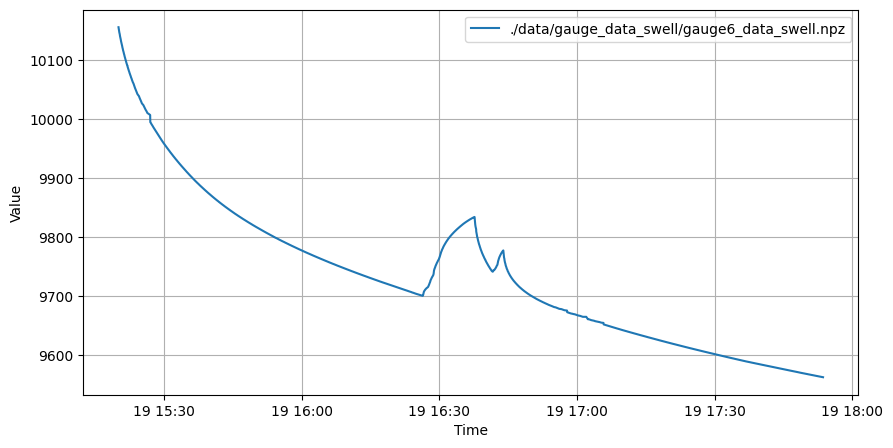

In [166]:
phase_2_pg_dataframe.plot()

In [167]:
pds_frame_phase2.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 14524 Source term: [10156.084, 10156.084, 10156.084, 10156.084, 10156.084, 10156.084]
Time: 14548.109224749702 Source term: [10154.145334322797, 10154.145334322797, 10154.145334322797, 10154.145334322797, 10154.145334322797, 10154.145334322797]
Time: 14578.109224749702 Source term: [10137.186047390434, 10137.186047390434, 10137.186047390434, 10137.186047390434, 10137.186047390434, 10137.186047390434]
Time: 14608.109224749702 Source term: [10119.03064160355, 10119.03064160355, 10119.03064160355, 10119.03064160355, 10119.03064160355, 10119.03064160355]
Time: 14638.109224749702 Source term: [10103.936609058952, 10103.936609058952, 10103.936609058952, 10103.936609058952, 10103.936609058952, 10103.936609058952]
Time: 14668.109224749702 Source term: [10091.069189240978, 10091.069189240978, 10091.069189240978, 10091.069189240978, 10091.069189240978, 10091.069189240978]
Time: 14698.109224749702 Source term: [10078.052077204195, 10078.0520772041

In [168]:
pds_frame_phase2.source[0].taxis

array([0.000000e+00, 1.008000e+00, 2.019000e+00, ..., 9.216254e+03,
       9.218232e+03, 9.219249e+03])

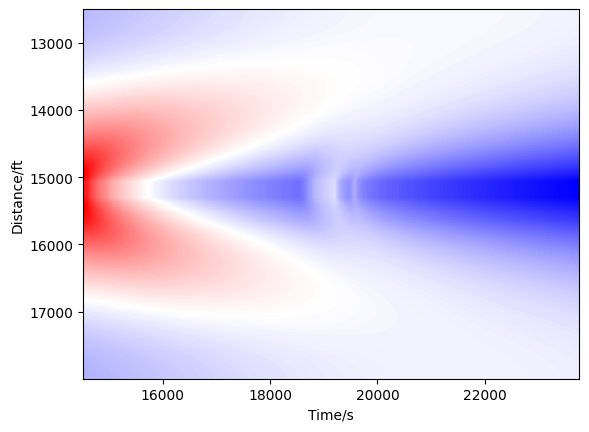

In [169]:
pds_frame_phase2.plot_solution()

# Phase 3

In [183]:
# Change diffusivity ratio
diffusivity_change_ratio = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001]) # add more instances

In [184]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [185]:
# First for test, only use the first diffusivity ratio
pds_frame_phase3 = pds.PDS1D_MultiSource()
pds_frame_phase3.set_mesh(x)
pds_frame_phase3.set_bcs('Neumann', 'Neumann')
pds_frame_phase3.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2

In [186]:
pds_frame_phase3.set_sourceidx(frac_hit_idx_stg8)

In [187]:
# Set the diffusivity
d_pahse3 = np.ones_like(x) * d
# change the diffusivity at the frac hit location at stage 7
for frac_hit_idx_iter in frac_hit_idx_stg7:
    d_pahse3[frac_hit_idx_iter] = d * diffusivity_change_ratio[-1]
pds_frame_phase3.set_diffusivity(d_pahse3)

In [188]:
phase_3_pg_dataframe = gauge_dataframe_next.copy()
phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)
phase_3_pg_dataframe.taxis -= phase_3_pg_dataframe.taxis[0]

In [189]:
source_phase3_list = []
for source_iter in range(len(frac_hit_idx_stg8)):
    source_phase3_list.append(phase_3_pg_dataframe)

In [190]:
pds_frame_phase3.set_source(source_phase3_list)

In [191]:
u_initial = pds_frame_phase2.snapshot[-1]

In [192]:
pds_frame_phase3.set_initial(u_initial)

In [193]:
pds_frame_phase3.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 23760.1092247497 Source term: [9562.775, 9562.775, 9562.775, 9562.775, 9562.775, 9562.775]
Time: 23767.048197572632 Source term: [9562.742439565865, 9562.742439565865, 9562.742439565865, 9562.742439565865, 9562.742439565865, 9562.742439565865]
Time: 23797.048197572632 Source term: [9562.561086819394, 9562.561086819394, 9562.561086819394, 9562.561086819394, 9562.561086819394, 9562.561086819394]
Time: 23827.048197572632 Source term: [9561.794682903708, 9561.794682903708, 9561.794682903708, 9561.794682903708, 9561.794682903708, 9561.794682903708]
Time: 23857.048197572632 Source term: [9561.042088191893, 9561.042088191893, 9561.042088191893, 9561.042088191893, 9561.042088191893, 9561.042088191893]
Time: 23887.048197572632 Source term: [9560.216796923562, 9560.216796923562, 9560.216796923562, 9560.216796923562, 9560.216796923562, 9560.216796923562]
Time: 23917.048197572632 Source term: [9559.47286384852, 9559.47286384852, 9559.47286384852, 9

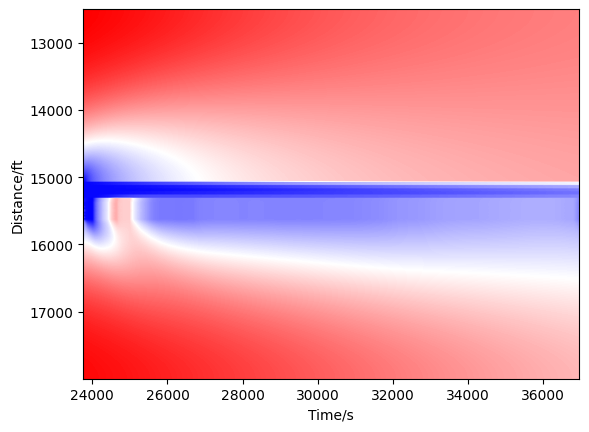

In [194]:
pds_frame_phase3.plot_solution()

# Phase 3 / Full

In [131]:
# Use all the diffusivity ratio to do the simulation.
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [132]:
# Initialize the phase 3 full solution
pds_frame_phase3_all = []

In [133]:
for diffusivity_iter in diffusivity_change_ratio[:-1]: # exclude the last one since it is already done in the previous cell
    pds_frame_phase3_iter = pds.PDS1D_MultiSource()
    pds_frame_phase3_iter.set_mesh(x)
    pds_frame_phase3_iter.set_bcs('Neumann', 'Neumann')
    pds_frame_phase3_iter.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
    # Set the source index
    pds_frame_phase3_iter.set_sourceidx(frac_hit_idx_stg8)
    # Set the diffusivity
    d_pahse3 = np.ones_like(x) * d
    # change the diffusivity at the frac hit location at stage 7
    for frac_hit_idx_iter in frac_hit_idx_stg7:
        d_pahse3[frac_hit_idx_iter] = d * diffusivity_iter
    pds_frame_phase3_iter.set_diffusivity(d_pahse3)
    # Set the source term
    phase_3_pg_dataframe = gauge_dataframe_next.copy()
    phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)
    source_phase3_list = []
    for source_iter in range(len(frac_hit_idx_stg8)):
        source_phase3_list.append(phase_3_pg_dataframe)
    pds_frame_phase3_iter.set_source(source_phase3_list)
    # Set the initial condition
    u_initial = pds_frame_phase2.snapshot[-1]
    pds_frame_phase3_iter.set_initial(u_initial)
    # Solve the problem
    pds_frame_phase3_iter.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)
    # Append the solution
    pds_frame_phase3_all.append(pds_frame_phase3_iter)

Time array generated using the source term.
Time: 23763.429788474958 Source term: [9530.631, 9530.631, 9530.631, 9530.631, 9530.631, 9530.631]
Time: 23768.87632827888 Source term: [9530.574, 9530.574, 9530.574, 9530.574, 9530.574, 9530.574]
Time: 23790.982264823662 Source term: [9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837]
Time: 23820.982264823662 Source term: [9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911]
Time: 23850.982264823662 Source term: [9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714]
Time: 23880.982264823662 Source term: [9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548]
Time: 23910.982264823662 Source term: [9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078]
Time: 

# Post-processing

Convert it to strain rate

In [195]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3.snapshot], axis=0)

In [196]:
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3.taxis], axis=0)

In [197]:
np.unique(np.diff(x))

array([0.13333333, 0.13333333, 1.        ])

In [198]:
extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]]

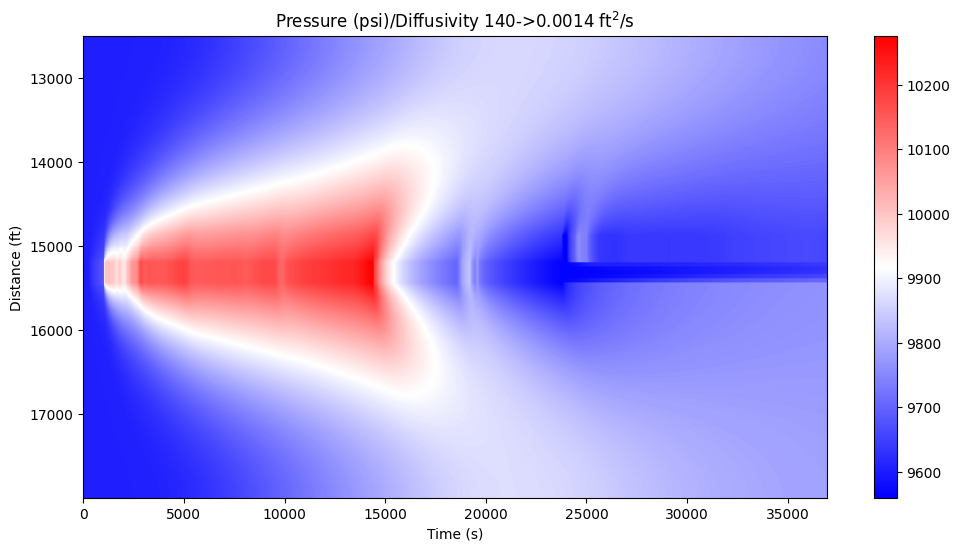

In [199]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr', extent=extent)
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title(f'Pressure (psi)/Diffusivity {d}->{d*diffusivity_change_ratio[-1]:.4f} ft$^2$/s')
plt.show()

## Convert the pressure field to strain rate

In [200]:
pressure_data_psi = snapshot_result_all
pressure_data_pa = pressure_data_psi * 6894.76
strain_from_pressure = pressure_data_pa / 30e9 # Hook's law

In [201]:
strain_rate_from_simulation = np.zeros_like(strain_from_pressure)
for i in range(strain_from_pressure.shape[1]):
    strain_rate_from_simulation[:, i] = np.gradient(strain_from_pressure[:, i], axis=0) / np.gradient(taxis_result_all)

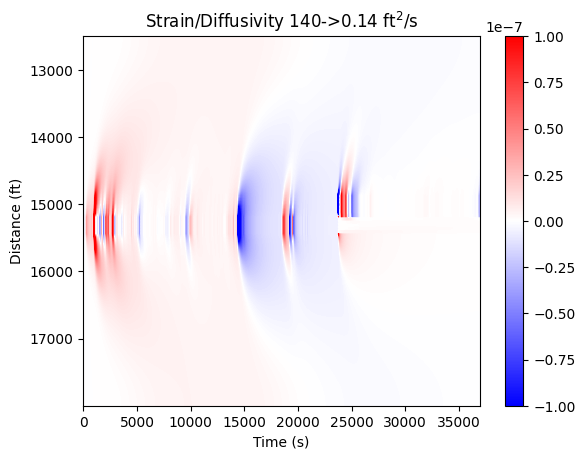

In [202]:
# Plot the solution
ax  = np.array([-1, 1])
plt.imshow(strain_rate_from_simulation.T, aspect='auto', cmap='bwr', extent=extent)
plt.clim(ax * 1e-7)
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Strain/Diffusivity 140->0.14 ft$^2$/s')
plt.show()

## Load DSS data

In [203]:
from DSS_analyzer_Mariner import Data2D_XT_DSS

In [204]:
import os

In [205]:
# Compare the results with the DAS data
DASdata_folder = datapath + "/DASdata/"
os.listdir(DASdata_folder)

['LFDASdata_stg8_swell.npz',
 'LFDASdata_stg7_interval_swell.npz',
 'LFDASdata_stg7_swell.npz']

In [206]:
stg7_DASdata = Data2D_XT_DSS.Data2D()
stg7_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg7_swell.npz")

In [207]:
stg7_DASdata_interval = Data2D_XT_DSS.Data2D()
stg7_DASdata_interval.loadnpz(DASdata_folder + "LFDASdata_stg7_interval_swell.npz")

In [208]:
stg8_DASdata = Data2D_XT_DSS.Data2D()
stg8_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg8_swell.npz")

In [209]:
# merge the DAS data
# DASdata_new = Data2D_XT_DSS.merge_data2D([DASdata, DASdata_interval, DASdata_next])
DASdata_all = Data2D_XT_DSS.merge_data2D([stg7_DASdata, stg7_DASdata_interval, stg8_DASdata])

In [210]:
depth_range = [np.min(frac_hit_md_stg8) - 500, np.max(frac_hit_md_stg7) + 500]

In [211]:
DASdata_all.select_depth(depth_range[0], depth_range[1])

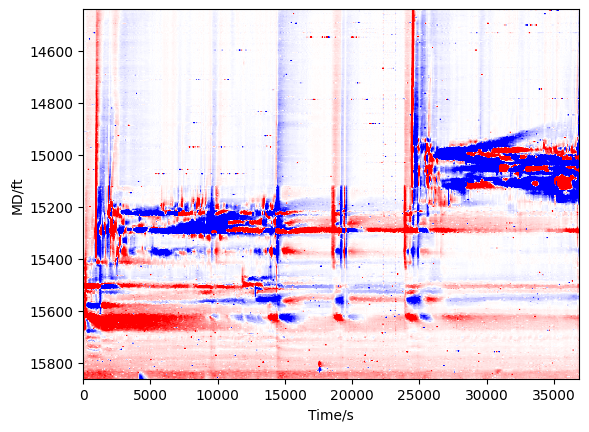

In [212]:
cx = np.array([-1, 1])
DASdata_all.plot_waterfall(use_timestamp=False)
plt.clim(cx * 1e3)
plt.xlabel("Time/s")
plt.ylabel("MD/ft")
plt.show()

## Compare the results

In [213]:
# Crop the simulation data
ind = (x >= depth_range[0]) & (x <= depth_range[1])
strain_rate_from_simulation_crop = strain_rate_from_simulation[:, ind]
x_crop = x[ind]

In [214]:
extent_crop = [extent[0], extent[1], x_crop[-1], x_crop[0]]

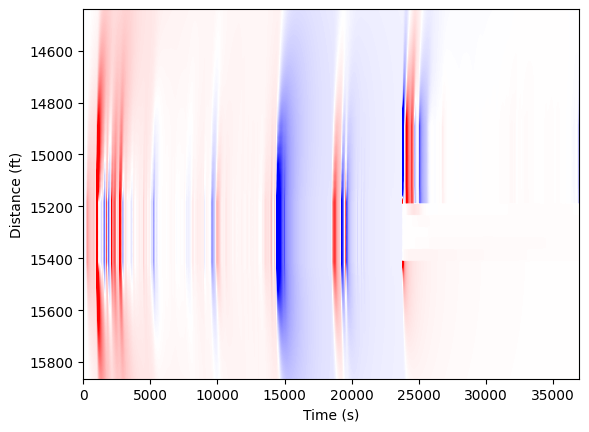

In [215]:
# Plot the solution
ax  = np.array([-1, 1])
plt.imshow(strain_rate_from_simulation_crop.T, aspect='auto', cmap='bwr', extent=extent_crop)
plt.clim(ax * 1e-7)
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.show()

## Compare the simulation with the gauge data

In [216]:
mesh_utils.locate(x, gauge_md[0])

(3255, 15599.0)

In [222]:
# Load the real pressure gauge data
real_pg_data = []
real_pg_data_taxis = []
gauge_num = [5, 6, 7, 8, 9, 10]
for num in gauge_num:
    gauge_dataframe = Data1D_Gauge.Data1DGauge(gauge_data_folder + f"/gauge{num}_data_swell.npz")
    gauge_dataframe.crop(stage7_start_time, stage8_end_time)
    time_sec = gauge_dataframe.calculate_time() * 3600
    real_pg_data.append(gauge_dataframe.data)
    real_pg_data_taxis.append(time_sec)

TypeError: Data1D.__init__() takes 1 positional argument but 2 were given

In [157]:
gauge_md

array([15599, 15344, 15075, 14821, 14552, 14297])

IndexError: list index out of range

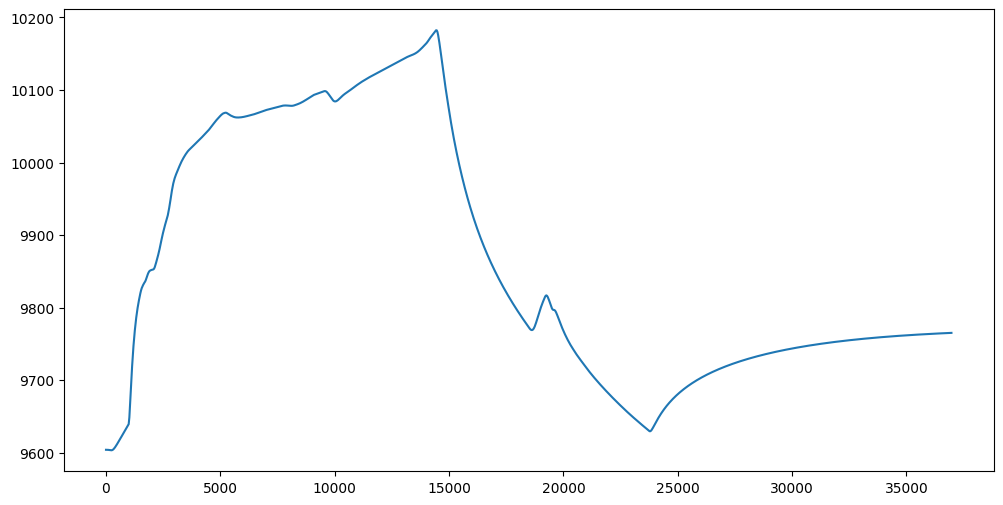

In [223]:
flag = 0
for gauge_iter in gauge_md:
    # Locate the gauge
    gauge_idx = mesh_utils.locate(x, gauge_iter)[0]
    # Plot the simulation result
    plt.figure(figsize=(12, 6))
    plt.plot(taxis_result_all, snapshot_result_all[:, gauge_idx], label='Simulation')
    # Plot the real data
    plt.plot(real_pg_data_taxis[flag], real_pg_data[flag], label='Real Data')
    plt.xlabel('Time/s')
    plt.ylabel('Pressure/psi')
    plt.title(f'Pressure Gauge {flag + 5}')
    plt.legend()
    plt.show()

    flag += 1


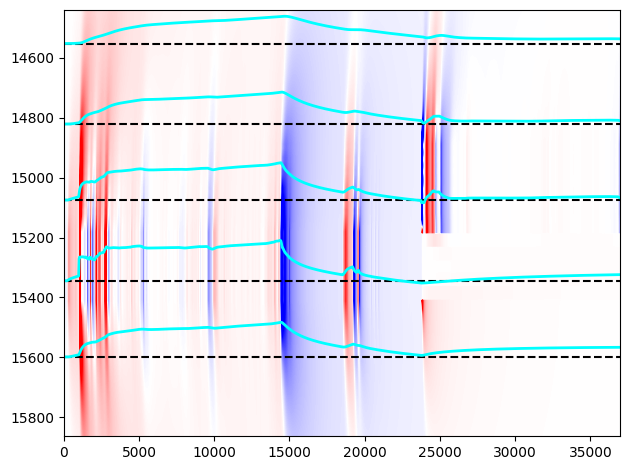

In [224]:
fig, ax1 = plt.subplots()
imag1 = ax1.imshow(strain_rate_from_simulation_crop.T, aspect='auto', cmap='bwr', extent=extent_crop)
imag1.set_clim(cx * 1e-7)
for i in range(len(gauge_md)-1):
    ax1.axhline(y=gauge_md[i], color='black', linestyle='--')
    gauge_idx = mesh_utils.locate(x, gauge_md[i])[0]
    ax1.plot(taxis_result_all, (snapshot_result_all[:, gauge_idx] - snapshot_result_all[0, gauge_idx]) * -0.2 + gauge_md[i], color='cyan', linewidth=2)
plt.tight_layout()
plt.show()